In [1]:
## Note that I did not include results combining two clusters in the hybrid simulations
## It seems that I have an error propagation problem on the hybrid simuation code
## i.e., when I combine two clusters, it seems that only the error of the second cluster is kept and propagated leading to non explainable results
## for instance, combining clusters "f" and "manual_1" yields to error lower than the cluster "f" only

In [2]:
# Package imports

import os.path as pth
import matplotlib.pyplot as plt # Matplotlib v3.5.1
import numpy as np # Numpy v1.23.4
import os
import json
import h5py
from typing import Union
import pandas as pd

from src.utils import set_rcParams

set_rcParams()

In [3]:
# Json file containing clusters informations

with open('clusters_informations_for_hybrid_simulations.json') as json_file:
    clusters_infos =  json.load(json_file)

In [18]:
# Functions used to read .mat results files

def generate_reduced_network_node_id_dict(clustered_nodes: list[int]) -> dict:
    """Generates dictionary to identify the remaining nodes from the original network nodes

    Args:
        clustered_nodes (list[int]): list of clustered nodes (in julia indexing)

    Returns:
        dict: dictionary to associate the original node id to the reduced network node ids
    """
    step = 0
    dict_ = {}
    for i in range(71): # There is 71 nodes in the case study network 1
        if (i+1) in clustered_nodes:
            step += 1
        dict_[i] = i-step
    return dict_

def prepocessing(dict_physical_values) -> dict:
    """Preprocess the read data from .mat files

    Args:
        dict_physical_values (dict): the dictionary from the mat file

    Returns:
        dict: the improved and treated dict file
    """
    dict_ = {}
    # Some prepocessing
    first_dynamic_step_interest = 10*60
    last_dynamic_steps_horizon = first_dynamic_step_interest + 2*7*24*60 - 1 # 1 week only for minute-time steps

    for physical_state_key in dict_physical_values:
        array = np.array(dict_physical_values[physical_state_key])
        if physical_state_key in ['trcs', 'mc']: # We take all for those
            dict_[physical_state_key] = array
        else:
            dict_[physical_state_key] = array[first_dynamic_step_interest:last_dynamic_steps_horizon,:]
    return dict_

def compute_mae_with_interval(distribution) -> tuple:
    """Computes the mean with interval confidence of 98%

    Args:
        distribution (numpy): the distribution

    Returns:
        tuple: (mean, +- confidence interval)
    """
    return np.mean(distribution), 1.96*np.std(distribution)/np.sqrt(len(distribution))

def get_hybrid_simulation_performances(scenario_dict_values: dict, model_key: str, clusters_keys:  Union[list[str],str], cluster_key_result: str = None, sources_to_consider=[0,56]) -> dict:
    """Reads the hybrid results and assess the reduced network simulation performances

    Args:
        scenario_dict_values (dict): the dictionary containing the scenario results including full physical and reduced networks
        model_key (str): the model considered [rnn, cnn]
        clusters_keys (Union[list[str],str]): the clusters keys
        cluster_key_result (str, optional): clusters key used for hybrid results name. Defaults to None.

    Raises:
        Exception: if cluster key not well defined

    Returns:
        dict: the dictionary of performances
    """
    incoming_pipes_ids = []
    incoming_pipes_ids_trout_nodes = []
    
    outgoing_pipes_ids = []
    outgoing_pipes_ids_tsout_nodes = []
    
    clustered_nodes = []
    associated_node_ids = dict()
    perfs = dict()
    
    if type(clusters_keys) == list:
        if cluster_key_result == None:
            raise Exception('Cluster key result must be defined for many clusters considered')
        for key in clusters_keys:
            cluster_info = clusters_infos[f'cluster_{key}']
            # print(cluster_info)
            incoming_pipes_ids.extend(cluster_info['incoming_pipes_id'])
            incoming_pipes_ids_trout_nodes.extend(cluster_info['incoming_pipes_remixing_node_id'])
            outgoing_pipes_ids.extend(cluster_info['outgoing_pipe_id'])
            outgoing_pipes_ids_tsout_nodes.extend(cluster_info['outgoing_pipe_remixing_node_id'])
            clustered_nodes.extend(cluster_info['cluster_nodes'])

        associated_node_ids = generate_reduced_network_node_id_dict(clustered_nodes)
        key = cluster_key_result # key to identify dict of results
        
    else:
        key = clusters_keys
        cluster_info = clusters_infos[f'cluster_{key}']
        # print(cluster_info)
        incoming_pipes_ids.extend(cluster_info['incoming_pipes_id'])
        incoming_pipes_ids_trout_nodes.extend(cluster_info['incoming_pipes_remixing_node_id'])
        outgoing_pipes_ids.extend(cluster_info['outgoing_pipe_id'])
        outgoing_pipes_ids_tsout_nodes.extend(cluster_info['outgoing_pipe_remixing_node_id'])
        clustered_nodes.extend(cluster_info['cluster_nodes'])
        associated_node_ids = generate_reduced_network_node_id_dict(cluster_info['cluster_nodes'])

    perfs['key'] = key
    perfs['type'] = cluster_info['cluster_type']
    perfs['clustered_nodes_number'] = len(clustered_nodes)
    perfs['clustered_nodes_percentage'] = 100*(len(clustered_nodes) / 71)
    perfs['clustered_pipes_percentage'] = 100*((len(clustered_nodes)+len(outgoing_pipes_ids)) / 71) # Tree-like assumption => number of nodes == number edges
    
    loads_mare_f = []
    loads_incoming_mare_f = []
    loads_outgoing_mare_f = []
    
    incoming_loads = 0
    incoming_mws = 0
    for i, el in enumerate(incoming_pipes_ids):
        el_i = incoming_pipes_ids_trout_nodes[i]
        pipe_index = int(el)-1 # Ingoing pipe index in the original network (needed for effective comparison) !! -1 as julia are indexed from 1
        node_index = int(el_i)-1 # Adjacent nodes to the cluster (in the return direction) !! -1 as julia are indexed from 1

        mw = np.abs(np.mean(scenario_dict_values['full_physic']['mw'][:,pipe_index]))
        # print(f'Original incoming pipe (scenario) {el} traversed by mass flow rates with nominal value of {mw:.2f} Kg/s')

        tr_node_mix = scenario_dict_values['full_physic']['tr'][:,node_index]
        ts_node_mix = scenario_dict_values['full_physic']['ts'][:,node_index]
            
        tr_node_mix_reduced = scenario_dict_values[model_key][key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = scenario_dict_values[model_key][key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_f.extend(100*(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        
        incoming_loads += np.mean(np.abs(pw_adj_node))
        incoming_mws += np.mean(np.abs(mw)) 
    
    outgoing_loads = 0
    outgoing_mws = 0
    for i, el in enumerate(outgoing_pipes_ids):
        el_i = outgoing_pipes_ids_tsout_nodes[i]
        pipe_index = int(el)-1
        node_index = int(el_i)-1
        
        mw = np.abs(np.mean(scenario_dict_values['full_physic']['mw'][:,pipe_index]))

        tr_node_mix = scenario_dict_values['full_physic']['tr'][:,node_index]
        ts_node_mix = scenario_dict_values['full_physic']['ts'][:,node_index]
        tr_node_mix_reduced = scenario_dict_values[model_key][key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = scenario_dict_values[model_key][key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_f.extend(100*(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        
        outgoing_loads += np.mean(np.abs(pw_adj_node))
        outgoing_mws += np.mean(np.abs(mw)) 
        
    mare_f, conf_f = compute_mae_with_interval(loads_mare_f)
    
    perfs['incoming_loads'] = incoming_loads
    perfs['outgoing_loads'] = outgoing_loads
    perfs['incoming_mws'] = incoming_mws
    perfs['outgoing_mws'] = outgoing_mws
    perfs['Thermal loads (MARE)'] = mare_f
    perfs['Thermal loads (MARE-Conf_interval)'] = conf_f
    perfs['Thermal loads (errors)'] = loads_mare_f
    
    mare_f, conf_f = compute_mae_with_interval(loads_mare_f)
    mare_f_in, conf_f_in = compute_mae_with_interval(loads_incoming_mare_f)
    mare_f_out, conf_f_out = compute_mae_with_interval(loads_outgoing_mare_f)
    
    perfs['Thermal loads incoming (MARE)'] = mare_f_in
    perfs['Thermal loads incoming (MARE-Conf_interval)'] = conf_f_in
    perfs['Thermal loads outgoing (MARE)'] = mare_f_out
    perfs['Thermal loads outgoing (MARE-Conf_interval)'] = conf_f_out
    
    perfs['Thermal loads (MARE)'] = mare_f
    perfs['Thermal loads (MARE-Conf_interval)'] = conf_f
    perfs['Thermal loads (errors)'] = loads_mare_f
        
    tr_node_source_f = scenario_dict_values['full_physic']['tr'][:,sources_to_consider].reshape(1,-1)
    ts_node_source_f = scenario_dict_values['full_physic']['ts'][:,sources_to_consider].reshape(1,-1)
    
    associated_sources_nodes_ids = [associated_node_ids[i] for i in sources_to_consider]
    tr_node_source_reduced_f = scenario_dict_values[model_key][key]['tr'][:,associated_sources_nodes_ids].reshape(1,-1)
    ts_node_source_reduced_f = scenario_dict_values[model_key][key]['ts'][:,associated_sources_nodes_ids].reshape(1,-1)

    mw_source_node_f = scenario_dict_values['full_physic']['mw'][:,sources_to_consider].reshape(1,-1)
    
    pw_adj_node_f = mw_source_node_f*4200*(ts_node_source_f-tr_node_source_f)
    pw_adj_node_reduced_f = mw_source_node_f*4200*(ts_node_source_reduced_f-tr_node_source_reduced_f)
    
    mae_r_f, conf_r_f = compute_mae_with_interval(np.abs(tr_node_source_f-tr_node_source_reduced_f))
    # print(f'Source return temperature conservation (scenario) MAE = {mae_r_f:.4f} °C +- {conf_r_f:.4f}') 
    perfs['Source return temp (MAE)'] = mae_r_f
    perfs['Source return temp (MAE-Conf_interval)'] = conf_r_f
    perfs['Source return temp (errors)'] = np.abs(tr_node_source_f-tr_node_source_reduced_f)

    mare_pw_f, conf_pw_f = compute_mae_with_interval(100*np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f))
    # print(f'Source generation power conservation (scenario) MARE = {mare_pw_f:.4f} % +- {conf_pw_f:.4f}') 
    perfs['Source gen (MARE)'] = mare_pw_f
    perfs['Source gen (MARE-Conf_interval)'] = conf_pw_f
    perfs['Source gen (errors)'] = 100*np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f)
    
    return perfs

### **First scenario results**

In [19]:
# Reading results 

folder = os.path.join('ARTICLE_hybrid_results', 'first scenario')
first_scenario_results = {}
# Note: non present values are extrapolated
# Les demandes ne sont pas modifiés trop dont utiliser l'autre 
# 1st scenario == ts var mais demandes differentes

full_network_physical_file_path = os.path.join(folder, 'new_simulation_data_original_var_tss_dhn1_new_new.mat')
first_scenario_results['full_physic'] = h5py.File(full_network_physical_file_path, 'r') # Dict ['load', 'mc', 'mw', 'topology_load', 'tr', 'trcs', 'trin', 'trout', 'ts', 'tsin', 'tsout']
first_scenario_results['full_physic'] = prepocessing(first_scenario_results['full_physic'])
for cluster_key in ['a', 'b', 'd', 'e', 'f', 'g', 'i', 'm', 'g_manual_1']:
    for model in ['cnn', 'rnn']:
        if model not in first_scenario_results:
            first_scenario_results[model] = {}
        reduced_file_path_rnn = os.path.join(folder, f'hybrid_cluster_{cluster_key}_var_tss_{model}_new_new.mat')
        if os.path.exists(reduced_file_path_rnn):
            dict_values = h5py.File(reduced_file_path_rnn, 'r')
            first_scenario_results[model][cluster_key] = prepocessing(dict_values)
        else:
            print(f'Cluster {cluster_key} not in 1st scenario results for model {model}')

sources = [0] # can add '56'
perfs_per_models = {}
for model in ['rnn', 'cnn']:
    perfs_per_models[model] = {}
    for key in ['a', 'b', 'd', 'e', 'f', 'i', 'g', 'm', 'g_manual_1']: # Note that in the article we do not consider combinaison clusters
        if key in first_scenario_results[model]:
            if key == 'g_manual_1':
                perfs_per_models[model][key] = get_hybrid_simulation_performances(first_scenario_results, model, ['g', 'manual_1'], cluster_key_result='g_manual_1', sources_to_consider=sources)
            else:
                perfs_per_models[model][key] = get_hybrid_simulation_performances(first_scenario_results, model, key, sources_to_consider=sources)

Cluster i not in 1st scenario results for model rnn
Cluster m not in 1st scenario results for model rnn
Cluster g_manual_1 not in 1st scenario results for model cnn


c:\Users\d22rodri\Desktop\WORKS\1st_article_folders_git\ML_clusters\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\d22rodri\Desktop\WORKS\1st_article_folders_git\ML_clusters\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\d22rodri\Desktop\WORKS\1st_article_folders_git\ML_clusters\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\d22rodri\Desktop\WORKS\1st_article_folders_git\ML_clusters\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\d22rodri\Desktop\WORKS\1st_article_folders_git\ML_clusters\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid va

In [20]:
# Saving to pickle formats

folder_scenario_1 = 'scenario_1_results'
if not os.path.isdir(folder_scenario_1):
    os.mkdir(folder_scenario_1)

import json
import pickle 
# Saving all considered clusters ['a', 'b', 'd', 'e', 'f', 'i', 'g', 'm']:
for key in ['a', 'b', 'd', 'e', 'f']:
    for model in ['rnn', 'cnn']:
        try:
            hybrid_results = perfs_per_models[model][key]
            with open(os.path.join(folder_scenario_1, f'results_{model}_{key}.pkl'), 'wb') as f:
                pickle.dump(hybrid_results, f)
        except Exception as ex:
            print(ex)

with open(os.path.join(folder_scenario_1, f'results_full_network.pkl'), 'wb') as f:
    pickle.dump(first_scenario_results['full_physic'], f)

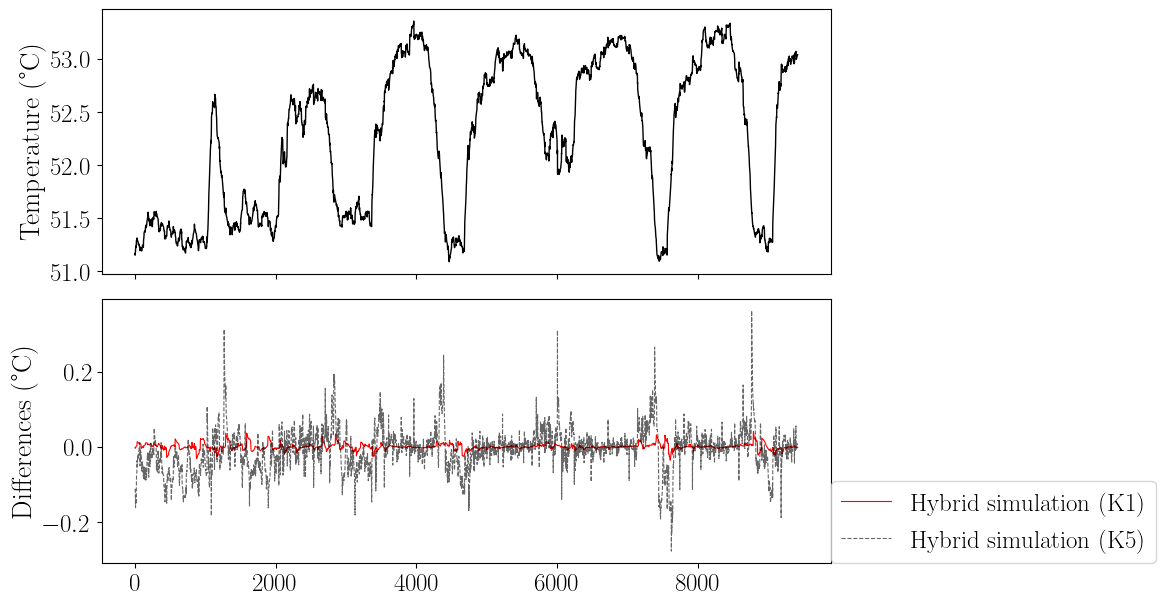

In [21]:
fig, axes = plt.subplots(figsize=(8,6), nrows=2, height_ratios=[1,1], sharex=True)
fig.tight_layout(pad=0.1)
# axes[0].plot(np.sum(first_scenario_results['full_physic']['load'],axis=1)*1e-6, c='black')
# axes[1].plot(first_scenario_results['full_physic']['ts'][:,0], c='black')
axes[0].plot(first_scenario_results['full_physic']['tr'][:,0], c='black')
axes[0].set_ylabel('Temperature (°C)')
# axes[0].plot(first_scenario_results['rnn']['a']['tr'][:,0], c='red')
# axes[0].plot(first_scenario_results['rnn']['b']['tr'][:,0], '--', c='black')
axes[1].plot(first_scenario_results['full_physic']['tr'][:,0] - first_scenario_results['rnn']['a']['tr'][:,0], linewidth=0.8, label='Hybrid simulation (K1)')
axes[1].plot(first_scenario_results['full_physic']['tr'][:,0] - first_scenario_results['rnn']['f']['tr'][:,0], '--', c='black', linewidth=0.8, alpha=0.6, label='Hybrid simulation (K5)')
# axes[1].plot(first_scenario_results['full_physic']['tr'][:,0] - first_scenario_results['cnn']['m']['tr'][:,0], ',', markersize=1.1, alpha=0.6, label='Hybrid (K8)')
axes[1].set_ylabel('Differences (°C)')
axes[1].legend(loc=(1.0, 0)) # place legend outside
plt.show()

In [22]:
perfs_per_models['cnn']['m']['incoming_mws']

45.03317375548855

### **Second scenario results**

In [23]:
# Reading results 

folder = os.path.join('ARTICLE_hybrid_results')
second_scenario_results = {}
# Note: non present values are extrapolated
# Les demandes ne sont pas modifiés trop dont utiliser l'autre 

# full_network_physical_file_path = os.path.join(folder, 'new_simulation_data_original_step_tss_dhn1.mat')
full_network_physical_file_path = os.path.join(folder, 'original_scenario_2_mimiking_pre_results.mat')
second_scenario_results['full_physic'] = h5py.File(full_network_physical_file_path, 'r') # Dict ['load', 'mc', 'mw', 'topology_load', 'tr', 'trcs', 'trin', 'trout', 'ts', 'tsin', 'tsout']
second_scenario_results['full_physic'] = prepocessing(second_scenario_results['full_physic'])
for cluster_key in ['a', 'b', 'd', 'e', 'f']:
    for model in ['cnn', 'rnn']:
        if model not in second_scenario_results:
            second_scenario_results[model] = {}
        reduced_file_path_rnn = os.path.join(folder, f'hybrid_cluster_{cluster_key}_step_tss_{model}.mat')
        if os.path.exists(reduced_file_path_rnn):
            dict_values = h5py.File(reduced_file_path_rnn, 'r')
            second_scenario_results[model][cluster_key] = prepocessing(dict_values)
        else:
            print(f'Cluster {cluster_key} not in 2nd scenario results for model {model}')

for cluster_key in ['g', 'i', 'm', 'g_manual_1']:
    for model in ['cnn', 'rnn']:
        if model not in second_scenario_results:
            second_scenario_results[model] = {}
        reduced_file_path_rnn_new = os.path.join(folder, f'hybrid_{cluster_key}_scenario_2_model_{model}.mat')
        if os.path.exists(reduced_file_path_rnn_new):
            dict_values = h5py.File(reduced_file_path_rnn_new, 'r')
            second_scenario_results[model][cluster_key] = prepocessing(dict_values)
        else:
            print(f'Cluster {cluster_key} not in 2nd scenario results for model {model}')

sources = [0] # can add '56'
perfs_per_models = {}
for model in ['rnn', 'cnn']:
    perfs_per_models[model] = {}
    for key in ['a', 'b', 'd', 'e', 'f', 'i', 'g', 'm', 'g_manual_1']: # take m from v2
        if key in second_scenario_results[model]:
            if key == 'g_manual_1':
                perfs_per_models[model][key] = get_hybrid_simulation_performances(second_scenario_results, model, ['g', 'manual_1'], cluster_key_result='g_manual_1', sources_to_consider=sources)
            else:
                perfs_per_models[model][key] = get_hybrid_simulation_performances(second_scenario_results, model, key, sources_to_consider=sources)

Cluster g_manual_1 not in 2nd scenario results for model cnn
Cluster g_manual_1 not in 2nd scenario results for model rnn


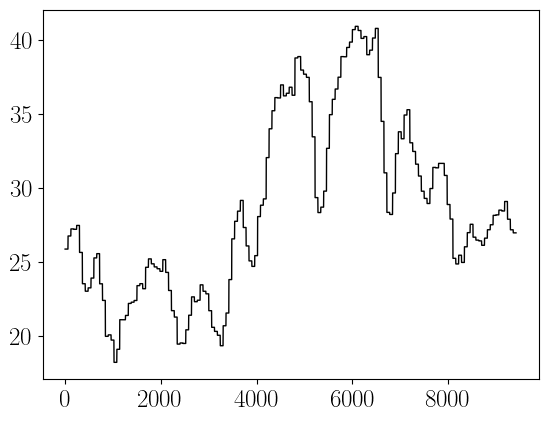

In [24]:
plt.plot(np.sum(second_scenario_results['full_physic']['topology_load'],axis=1)*1e-6, c='black')

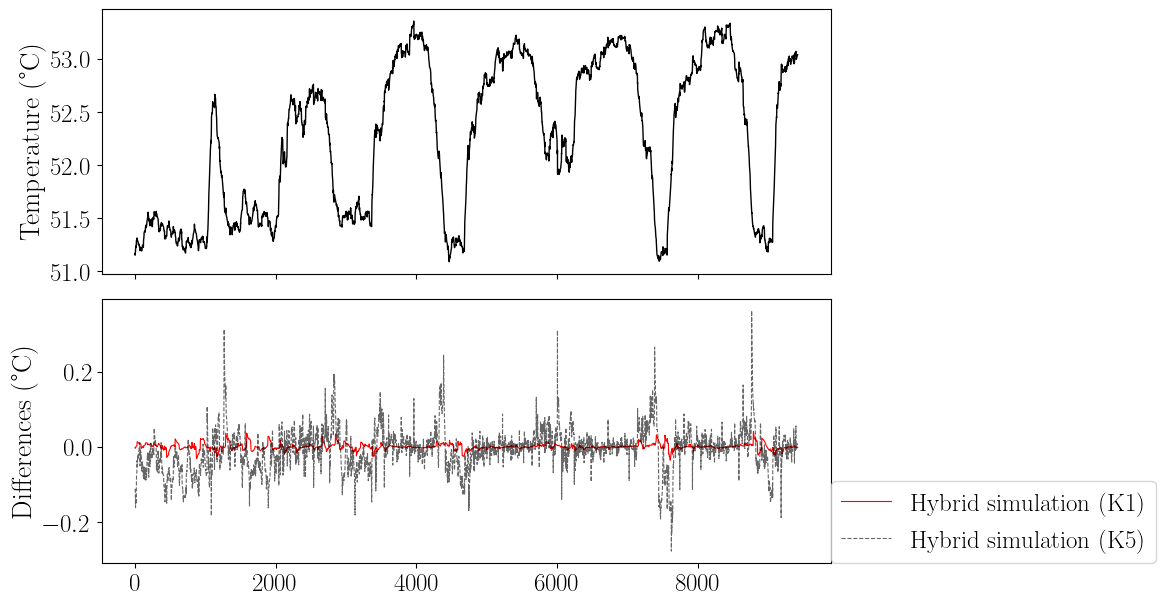

In [25]:
fig, axes = plt.subplots(figsize=(8,6), nrows=2, height_ratios=[1,1], sharex=True)
fig.tight_layout(pad=0.1)
# axes[0].plot(np.sum(first_scenario_results['full_physic']['load'],axis=1)*1e-6, c='black')
# axes[1].plot(first_scenario_results['full_physic']['ts'][:,0], c='black')
axes[0].plot(first_scenario_results['full_physic']['tr'][:,0], c='black')
axes[0].set_ylabel('Temperature (°C)')
# axes[0].plot(first_scenario_results['rnn']['a']['tr'][:,0], c='red')
# axes[0].plot(first_scenario_results['rnn']['b']['tr'][:,0], '--', c='black')
axes[1].plot(first_scenario_results['full_physic']['tr'][:,0] - first_scenario_results['rnn']['a']['tr'][:,0], linewidth=0.8, label='Hybrid simulation (K1)')
axes[1].plot(first_scenario_results['full_physic']['tr'][:,0] - first_scenario_results['rnn']['f']['tr'][:,0], '--', c='black', linewidth=0.8, alpha=0.6, label='Hybrid simulation (K5)')
# axes[1].plot(first_scenario_results['full_physic']['tr'][:,0] - first_scenario_results['cnn']['m']['tr'][:,0], ',', markersize=1.1, alpha=0.6, label='Hybrid (K8)')
axes[1].set_ylabel('Differences (°C)')
axes[1].legend(loc=(1.0, 0)) # place legend outside
plt.show()

In [26]:
second_scenario_results['rnn']['a'].keys()

dict_keys(['load', 'mc', 'mw', 'topology_load', 'tr', 'trcs', 'trin', 'trout', 'ts', 'tsin', 'tsout'])

In [27]:
perfs_per_models['rnn']['a']['Source gen (MARE)']

0.0019422212308643483

In [28]:
# Saving to pickle formats

folder_scenario_2 = 'scenario_2_results'
if not os.path.isdir(folder_scenario_2):
    os.mkdir(folder_scenario_2)

import json
import pickle
# Saving all considered clusters ['a', 'b', 'd', 'e', 'f', 'i', 'g', 'm']:
for key in ['a', 'b', 'd', 'e', 'f', 'i', 'g', 'm']:
    for model in ['rnn', 'cnn']:
        try:
            hybrid_results = perfs_per_models[model][key]
            with open(os.path.join(folder_scenario_2, f'results_{model}_{key}.pkl'), 'wb') as f:
                pickle.dump(hybrid_results, f)
        except Exception as ex:
            print(ex)

with open(os.path.join(folder_scenario_2, f'results_full_network.pkl'), 'wb') as f:
    pickle.dump(second_scenario_results['full_physic'], f)

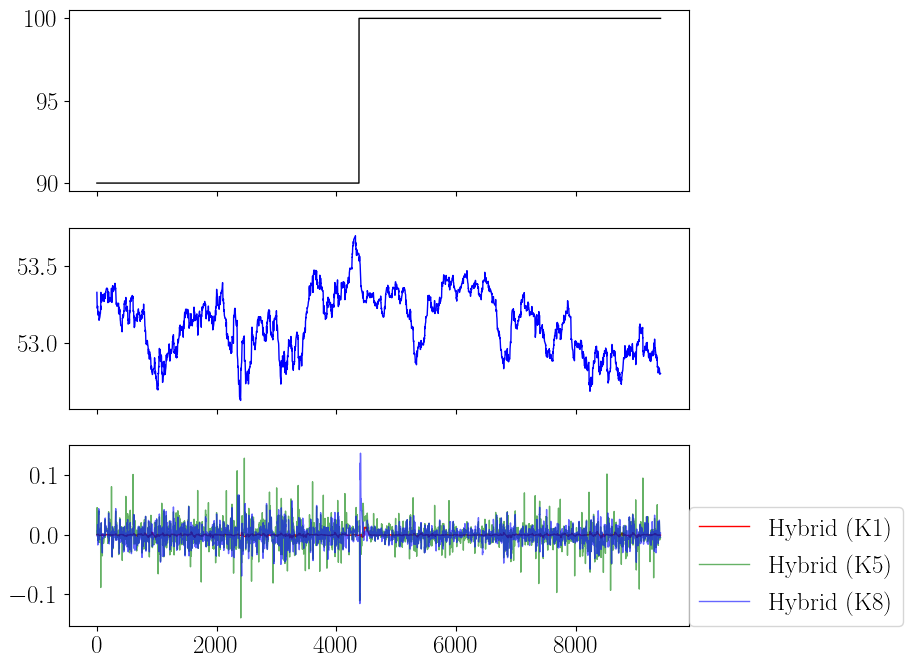

In [29]:
fig, axes = plt.subplots(figsize=(8,8), nrows=3, height_ratios=[1,1,1], sharex=True)
# axes[0].plot(np.sum(second_scenario_results['full_physic']['load'],axis=1)*1e-6, c='black')
axes[0].plot(second_scenario_results['full_physic']['ts'][:,0], c='black')
axes[1].plot(second_scenario_results['full_physic']['tr'][:,0], c='blue')
axes[2].plot(second_scenario_results['full_physic']['tr'][:,0] - second_scenario_results['rnn']['a']['tr'][:,0], label='Hybrid (K1)')
axes[2].plot(second_scenario_results['full_physic']['tr'][:,0] - second_scenario_results['rnn']['f']['tr'][:,0], alpha=0.6, label='Hybrid (K5)')
axes[2].plot(second_scenario_results['full_physic']['tr'][:,0] - second_scenario_results['rnn']['m']['tr'][:,0], alpha=0.6, label='Hybrid (K8)')
axes[2].legend(loc=(1.0, 0)) # place legend outside
plt.show()

#### **Third scenario results**

In [22]:
# Reading results 

folder = os.path.join('ARTICLE_hybrid_results', 'third scenario')
thrid_scenario_results = {}
# Note: non present values are extrapolated
# Les demandes ne sont pas modifiés trop dont utiliser l'autre 

full_network_physical_file_path = os.path.join(folder, 'original_scenario_3.mat')
thrid_scenario_results['full_physic'] = h5py.File(full_network_physical_file_path, 'r') # Dict ['load', 'mc', 'mw', 'topology_load', 'tr', 'trcs', 'trin', 'trout', 'ts', 'tsin', 'tsout']
thrid_scenario_results['full_physic'] = prepocessing(thrid_scenario_results['full_physic'])
for cluster_key in ['a', 'b', 'd', 'e', 'f', 'g', 'i', 'm', 'g_manual_1']:
    for model in ['cnn', 'rnn']:
        if model not in thrid_scenario_results:
            thrid_scenario_results[model] = {}
        reduced_file_path_rnn = os.path.join(folder, f'hybrid_{cluster_key}_scenario_3_model_{model}.mat')
        if os.path.exists(reduced_file_path_rnn):
            dict_values = h5py.File(reduced_file_path_rnn, 'r')
            thrid_scenario_results[model][cluster_key] = prepocessing(dict_values)
        else:
            print(f'Cluster {cluster_key} not in 3rd scenario results for model {model}')

sources = [0] # can add '56'
perfs_per_models = {}
for model in ['rnn', 'cnn']:
    perfs_per_models[model] = {}
    for key in ['a', 'b', 'd', 'e', 'f', 'i', 'g', 'm', 'g_manual_1']: # take m from v2
        if key in thrid_scenario_results[model]:
            if key == 'g_manual_1':
                perfs_per_models[model][key] = get_hybrid_simulation_performances(thrid_scenario_results, model, ['g', 'manual_1'], cluster_key_result='g_manual_1', sources_to_consider=sources)
            else:
                perfs_per_models[model][key] = get_hybrid_simulation_performances(thrid_scenario_results, model, key, sources_to_consider=sources)

In [23]:
# Saving to pickle formats

folder_scenario_3 = 'scenario_3_results'
if not os.path.isdir(folder_scenario_3):
    os.mkdir(folder_scenario_3)

import json
import pickle
# Saving all considered clusters ['a', 'b', 'd', 'e', 'f', 'i', 'g', 'm']:
for key in ['a', 'b', 'd', 'e', 'f', 'i', 'g', 'm']:
    for model in ['rnn', 'cnn']:
        try:
            hybrid_results = perfs_per_models[model][key]
            with open(os.path.join(folder_scenario_3, f'results_{model}_{key}.pkl'), 'wb') as f:
                pickle.dump(hybrid_results, f)
        except Exception as ex:
            print(ex)

with open(os.path.join(folder_scenario_3, f'results_full_network.pkl'), 'wb') as f:
    pickle.dump(thrid_scenario_results['full_physic'], f)

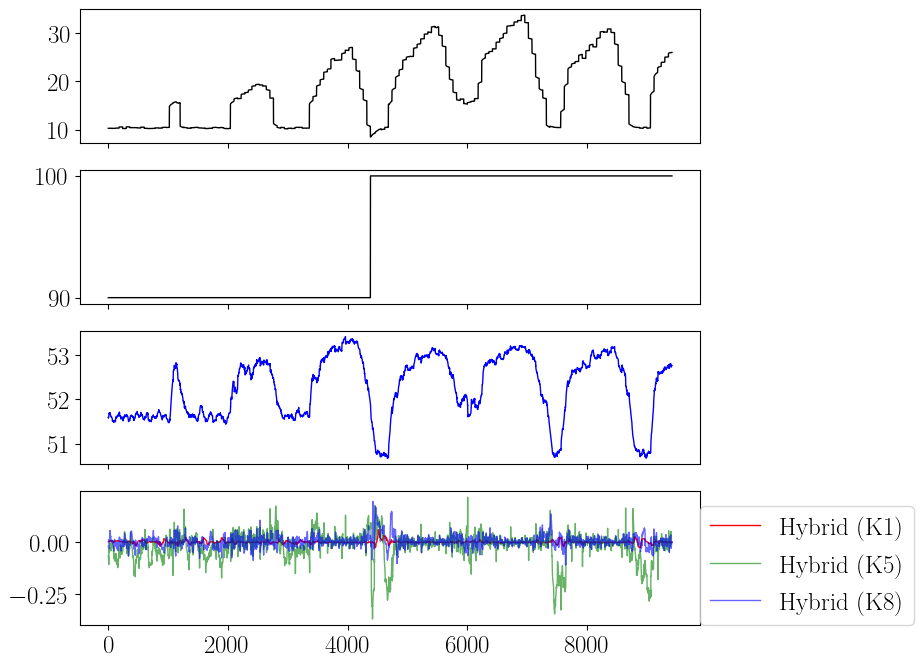

In [38]:
fig, axes = plt.subplots(figsize=(8,8), nrows=4, height_ratios=[1,1,1,1], sharex=True)
axes[0].plot(np.sum(thrid_scenario_results['full_physic']['load'],axis=1)*1e-6, c='black')
axes[1].plot(thrid_scenario_results['full_physic']['ts'][:,0], c='black')
axes[2].plot(thrid_scenario_results['full_physic']['tr'][:,0], c='blue')
axes[3].plot(thrid_scenario_results['full_physic']['tr'][:,0] - thrid_scenario_results['rnn']['a']['tr'][:,0], label='Hybrid (K1)')
axes[3].plot(thrid_scenario_results['full_physic']['tr'][:,0] - thrid_scenario_results['rnn']['f']['tr'][:,0], alpha=0.6, label='Hybrid (K5)')
axes[3].plot(thrid_scenario_results['full_physic']['tr'][:,0] - thrid_scenario_results['rnn']['m']['tr'][:,0], alpha=0.6, label='Hybrid (K8)')
axes[3].legend(loc=(1.0, 0)) # place legend outside
plt.show()